In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit
from qiskit.test.mock import FakeAthens
from qiskit.ignis.experiments.calibration import mock

fake_backend = FakeAthens()

## Model

Basis gate can be further lowered into instructions. For example:

$$
U2(\phi, \lambda) = RZ(\phi).RY(\frac{\pi}{2}).RZ(\lambda)
$$

In context of calibration, we need to prepare database with these atomic instructions. In what follows, this database is called _calibration table_ or just _table_.
This table is quite similar to the `InstructionScheduleMap` of qiskit-terra, but have additional functionalities for calibration.
With the generator model in the experimental framework, we don't need to prepare entry for composite gate. Any composite instruction can be constructed by the generator $G$ if the generator knows the name of all underlying atomic instructions. Arbitrary schedule can be constructed by acquiring atomic instruction data from the table $T$. For example:

$$
G(\{ U_{90+, 0}, U_{90+, 1}, U_{90-, 0}, U_{90-, 1}, X_{0} \}) \longrightarrow {\rm CR_{10}}, \hspace{2mm} {\rm where~.e.g.} \hspace{5mm} T({\rm u90p, 0}) = U_{90+,0}
$$

So we need to feed calibration table into a generator, and the generator internally assembles required pulse sequence. If an entry in the table is parametrized, generated sequence will be also paramerterized.

Finally, we can construct basis gates with the complete calibration table. This requires system information such as relationship of channel frames.

$$
{\rm calibration~table~} T \longrightarrow \{\rm basis~gate\}
$$

## 1. Loading calibration table

Load calibration table from server. This is just a mock:

In [3]:
cal_db = mock.FakeDatabase(backend_name=fake_backend.name(), num_qubits=fake_backend.configuration().n_qubits)

In [4]:
table = cal_db.load_calibrations()
table.get_properties('x90p', qubits=[0])

{'duration': 160, 'amp': 0, 'sigma': 40, 'beta': 0}

Once this table is provided, we can write calibration circuit with query like access to underlying gates:

---
```python
def ramsey_xy(
        name: str,
        table: cal_table.CalibrationDataTable,
        target_qubits: List[int],
        meas_basis: Optional[str] = 'z') -> types.CalProg:
    """Generate Ramsey circuit."""
    if len(target_qubits) != 1:
        raise CalExpError(
            'Invalid number of qubits = {} is specified.'
            'This experiment requires 1 qubit.'.format(len(target_qubits)))

    delay_param = circuit.Parameter('delay')

    with cal_builder.build(name=name,
                           qubits=target_qubits,
                           table=table,
                           meas_basis=meas_basis) as circ_x:
        cal_builder.atomic_gate(name=Insts.X90P.value, qubits=target_qubits)
        circ_x.delay(delay_param, unit='ns', qarg=[0])
        cal_builder.atomic_gate(name=Insts.X90P.value, qubits=target_qubits)

    with cal_builder.build(name=name,
                           qubits=target_qubits,
                           table=table,
                           meas_basis=meas_basis) as circ_y:
        cal_builder.atomic_gate(name=Insts.X90P.value, qubits=target_qubits)
        circ_y.delay(delay_param, unit='ns', qarg=[0])
        cal_builder.atomic_gate(name=Insts.Y90P.value, qubits=target_qubits)

    meta_x = {
        'generator': 'ramsey',
        'meas_basis': meas_basis,
        'quad': 'x'
    }
    meta_y = {
        'generator': 'ramsey',
        'meas_basis': meas_basis,
        'quad': 'y'
    }

    return types.CalProg(
        circuits=[circ_x, circ_y],
        metadata=[meta_x, meta_y]
    )
```
---

We can parametrize arbitrary parameter. This retunrs a handler of the parameter. Parameter name is generated based on the corresponding generator argument with the namespace generated by the pulse name and channel.

In [5]:
parameter = table.parametrize('x90p', qubits=[0], param_name='amp')

In [6]:
parameter

Parameter(x90p.d0.amp)

Table can return gate as well. This object can be attached to quantum circuit for calibration.

In [7]:
qc = qiskit.QuantumCircuit(1)
qc.append(table.get_gate('x90p', qubits=[0]), [0])
qc.draw()

┌───────────────────┐
q_0: ┤ x90p(x90p.d0.amp) ├
     └───────────────────┘

In [8]:
qc.parameters

{Parameter(x90p.d0.amp)}

We have these atomic instructions for single qubit gates.
```python
class SingleQubitAtomicPulses(Enum):
    """Name of single qubit gates."""
    X90P = 'x90p'
    X90M = 'x90m'
    Y90P = 'y90p'
    Y90M = 'y90m'
    XP = 'xp'
    XM = 'xm'
    YP = 'yp'
    YM = 'ym'
    STIM = 'stimulus'
```

## 2. Calibration

In [9]:
from qiskit.ignis.experiments.calibration.methods import RoughAmplitudeCalibration

import numpy as np

In [10]:
%%time
experiment = RoughAmplitudeCalibration(
    table=table,
    qubit=3,
    amp_vals=np.linspace(-0.5, 0.5, 31)
)

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 58.4 ms


In [11]:
cal_circuits = experiment.generator.circuits()

In [12]:
cal_circuits[0].draw()

┌──────────────────────────────┐ ░ ┌─┐
q_0: ┤ stimulus(-0.500000000000000) ├─░─┤M├
     └──────────────────────────────┘ ░ └╥┘
c: 1/════════════════════════════════════╩═
                                         0

In [13]:
cal_circuits[1].draw()

┌──────────────────────────────┐ ░ ┌─┐
q_0: ┤ stimulus(-0.466666666666667) ├─░─┤M├
     └──────────────────────────────┘ ░ └╥┘
c: 1/════════════════════════════════════╩═
                                         0

In [14]:
cal_circuits[-1].draw()

┌─────────────────────────────┐ ░ ┌─┐
q_0: ┤ stimulus(0.500000000000000) ├─░─┤M├
     └─────────────────────────────┘ ░ └╥┘
c: 1/═══════════════════════════════════╩═
                                        0

In [15]:
cal_metadata = experiment.generator.metadata()

In [16]:
cal_metadata[0]

{'generator': 'rabi',
 'meas_basis': 'z',
 'stimulus.d3.amp': -0.5,
 'name': 'rough_amplitude',
 'qubits': [3]}

In [17]:
cal_metadata[1]

{'generator': 'rabi',
 'meas_basis': 'z',
 'stimulus.d3.amp': -0.4666666666666667,
 'name': 'rough_amplitude',
 'qubits': [3]}

In [18]:
cal_metadata[-1]

{'generator': 'rabi',
 'meas_basis': 'z',
 'stimulus.d3.amp': 0.5,
 'name': 'rough_amplitude',
 'qubits': [3]}

Check embedded calibration.

In [19]:
cal_circuits[0].calibrations

{'stimulus': {((3,),
   (-0.5,)): Schedule((0, ShiftPhase(0, DriveChannel(3))), (0, ShiftFrequency(0.0, DriveChannel(3))), (0, Play(Drag(duration=160, amp=(-0.5+0j), sigma=40, beta=0), DriveChannel(3), name='stimulus')), (160, ShiftPhase(0, DriveChannel(3))), (160, ShiftFrequency(0.0, DriveChannel(3))), name="stimulus")}}

In [20]:
cal_circuits[1].calibrations

{'stimulus': {((3,),
   (-0.4666666666666667,)): Schedule((0, ShiftPhase(0, DriveChannel(3))), (0, ShiftFrequency(0.0, DriveChannel(3))), (0, Play(Drag(duration=160, amp=(-0.4666666666666667+0j), sigma=40, beta=0), DriveChannel(3), name='stimulus')), (160, ShiftPhase(0, DriveChannel(3))), (160, ShiftFrequency(0.0, DriveChannel(3))), name="stimulus")}}

In [21]:
cal_circuits[-1].calibrations

{'stimulus': {((3,),
   (0.5,)): Schedule((0, ShiftPhase(0, DriveChannel(3))), (0, ShiftFrequency(0.0, DriveChannel(3))), (0, Play(Drag(duration=160, amp=(0.5+0j), sigma=40, beta=0), DriveChannel(3), name='stimulus')), (160, ShiftPhase(0, DriveChannel(3))), (160, ShiftFrequency(0.0, DriveChannel(3))), name="stimulus")}}

Check program to submit.

In [22]:
compiled = experiment.schedules(backend=fake_backend)

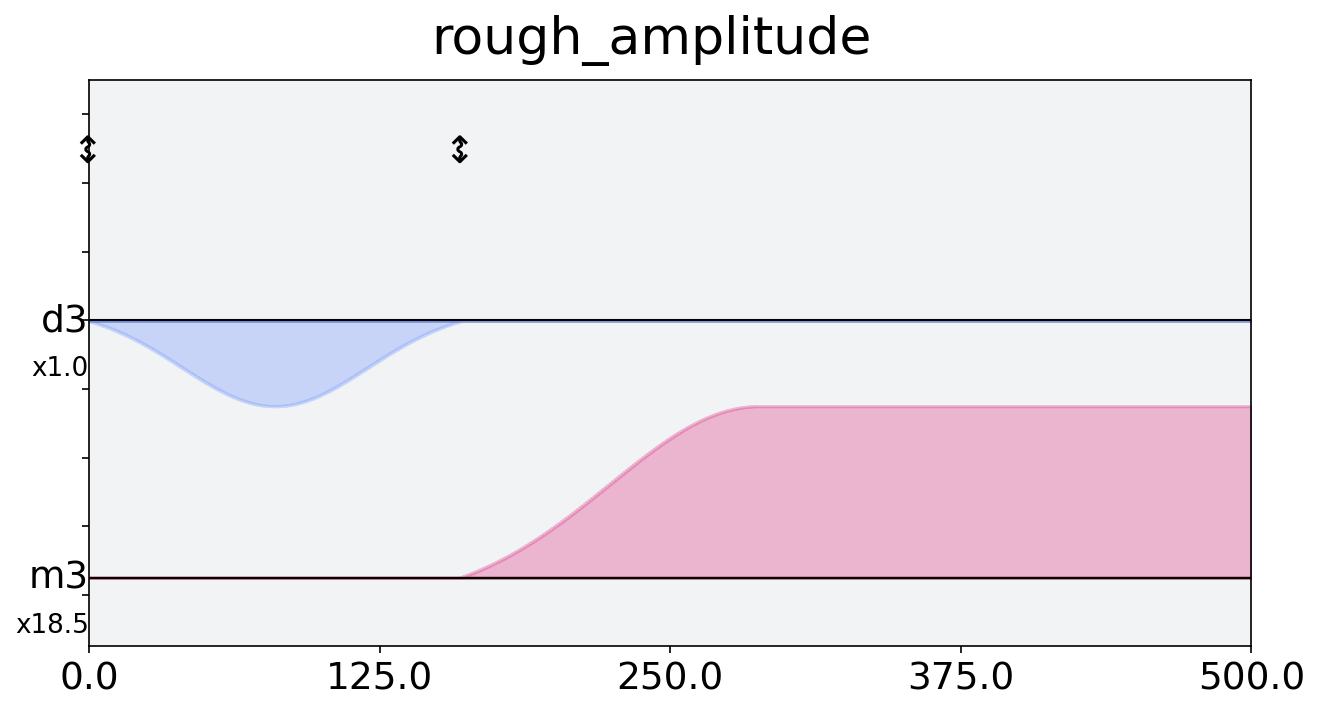

In [23]:
compiled[0].draw(plot_range=(0, 500), channel_scales={qiskit.pulse.DriveChannel(3): 1}, channels=[qiskit.pulse.DriveChannel(3), qiskit.pulse.MeasureChannel(3)], style=qiskit.visualization.SchedStyle(figsize=(10, 5)))

The actual experiment class looks like::

---
```python
class RoughAmplitudeCalibration(cal_base.BaseCalibrationExperiment):

    # pylint: disable=arguments-differ
    def __init__(self,
                 table: cal_table.CalibrationDataTable,
                 qubit: int,
                 amp_vals: np.ndarray,
                 analysis: Optional[Analysis] = None,
                 job: Optional = None):
        entry = types.SingleQubitAtomicPulses.STIM.value

        if not table.has(
            instruction=entry,
            qubits=[qubit]
        ):
            raise CalExpError('Entry {name} does not exist. '
                              'Check your calibration table.'.format(name=entry))

        # parametrize table
        amp = table.parametrize(
            instruction=entry,
            qubits=[qubit],
            param_name='amp'
        )

        # setup generator
        generator = cal_base.BaseCalibrationGenerator(
            cal_name='rough_amplitude',
            target_qubits=[qubit],
            cal_generator=methods.rabi,
            table=table,
            meas_basis='z'
        )
        generator.assign_parameters({amp: amp_vals})

        super().__init__(generator=generator, analysis=analysis, job=job)
```
---

Here at the constructor calibration table is parametrized and feed into generator. Parameter handler is used when assigining scanning parameters. You also need to write a function that generates circuits from the calibration table. Note that below function can be reused for experiment of rough frequency scan, i.e. changing scanning parameter from `amp` to `frequency` (TBD).


---
```python
def rabi(
        name: str,
        table: cal_table.CalibrationDataTable,
        target_qubits: List[int],
        meas_basis: Optional[str] = 'z') -> types.CalProg:
    """Generate Rabi circuit."""
    if len(target_qubits) != 1:
        raise CalExpError(
            'Invalid number of qubits = {} is specified.'
            'This experiment requires 1 qubit.'.format(len(target_qubits)))

    with cal_builder.build(name=name,
                           qubits=target_qubits,
                           table=table,
                           meas_basis=meas_basis) as circ:
        cal_builder.atomic_gate(name=Insts.STIM.value, qubits=target_qubits)

    meta = {
        'generator': 'rabi',
        'meas_basis': meas_basis
    }

    return types.CalProg(circuits=[circ], metadata=[meta])
```
---

## TODOs:

### Simultaneous calibration:
If we have a device with topology 0-1-2-3-4 we can Simultaneously calibrate [0, 2, 4] and [1, 3] without ZZ noise (Without this optimization we cannot calibrate entire device at reasonable queueing cost). To enable this, we need pass-manager like program compiler for generator.
### Reference frequency initialization:
Each physical channel has reference frequency which is updated on a daily basis. If user calibration sequence has been running across calibration point, this may mess up the calibration result. Thus we need to manage channel frequency with atomic instructions. However, this frequency doesn't belong to the specific entry (in contrast to pulse sideband), thus we need another layer to manage this info.
### Calibration table to basis gates:
Some calibrations use circuit gate level instruction, i.e. `sdg-H` for Y-basis measuerment. Currently this instruction is compiled with backend default. Thus we need a pass to dynamically update calibration def of basis gates.
### Two qubit calibration: 
The same model can be applied.
### Measurement calibration:
Need different data model due to acquire instruction.
### Analysis module:
Import the model from expval module. Perhaps we need to consider the IQ data processing.